In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

In [2]:
mbike = pd.read_csv("Motorbike Only.csv")
print(mbike.shape)
mbike.columns

(34296, 24)


Index(['Unnamed: 0', 'year', 'month', 'day_of_week', 'hour', 'weekend',
       'description_id', 'bicycle', 'pedestrian', 'cars', '2_wheel_motor',
       'casualties', 'fatalities', 'serious_injuries', 'minor_injuries',
       'mb_casualties', 'severity', 'speed_limit', 'intersection',
       'road_position_horizontal', 'road_position_vertical', 'weather',
       'lighting', 'traffic_controls'],
      dtype='object')

## Early EDA before modelling

In [3]:
def quick_count(df, target_col, feature_col):
    '''Makes a count plot of (ideally) categorical variables for quick EDA'''
    return sns.countplot(data = df, x = target_col, hue = feature_col)

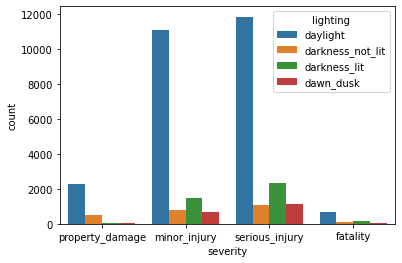

In [6]:
quick_count(mbike, 'severity', 'lighting')

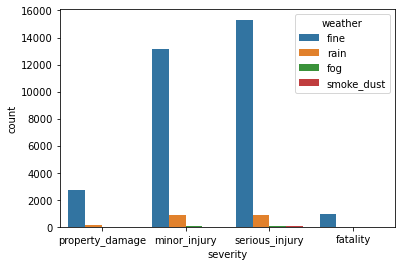

In [7]:
quick_count(mbike, 'severity', 'weather')

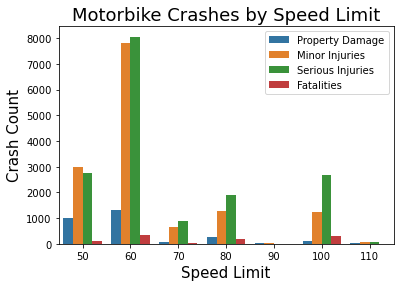

In [12]:
quick_count(mbike, 'speed_limit', 'severity')
plt.title("Motorbike Crashes by Speed Limit", size = 18)
plt.xlabel('Speed Limit', size = 15)
plt.ylabel('Crash Count', size = 15)
plt.legend(['Property Damage','Minor Injuries','Serious Injuries','Fatalities'])

In [ ]:
# Chance of serious injury increases the faster you ride, naturally

## Organise the model data

In [13]:
mbike.columns

Index(['Unnamed: 0', 'year', 'month', 'day_of_week', 'hour', 'weekend',
       'description_id', 'bicycle', 'pedestrian', 'cars', '2_wheel_motor',
       'casualties', 'fatalities', 'serious_injuries', 'minor_injuries',
       'mb_casualties', 'severity', 'speed_limit', 'intersection',
       'road_position_horizontal', 'road_position_vertical', 'weather',
       'lighting', 'traffic_controls'],
      dtype='object')

In [14]:
mb_mod = mbike.drop(['Unnamed: 0','year','description_id','bicycle','pedestrian', 'cars', '2_wheel_motor',
       'casualties', 'fatalities', 'serious_injuries', 'minor_injuries',
       'mb_casualties'], axis = 1)

In [15]:
mb_mod.head()

,month,day_of_week,hour,weekend,severity,speed_limit,intersection,road_position_horizontal,road_position_vertical,weather,lighting,traffic_controls
0,1,3,15,0,property_damage,60,1,straight,level,fine,daylight,none
1,1,5,16,0,property_damage,60,1,straight,level,fine,daylight,none
2,1,6,15,1,property_damage,60,1,straight,level,fine,daylight,giveway_sign
3,1,1,13,0,property_damage,50,1,straight,level,fine,daylight,giveway_sign
4,1,3,6,0,property_damage,60,1,straight,level,fine,daylight,traffic_lights


In [16]:
mb_mod['severity_ord'] = mb_mod['severity'].replace({'property_damage':0, 'minor_injury':1, 'serious_injury':2,
                                                      'fatality':3})

In [17]:
mb_mod.drop('severity', axis = 1, inplace = True)
mb_mod.head()

,month,day_of_week,hour,weekend,speed_limit,intersection,road_position_horizontal,road_position_vertical,weather,lighting,traffic_controls,severity_ord
0,1,3,15,0,60,1,straight,level,fine,daylight,none,0
1,1,5,16,0,60,1,straight,level,fine,daylight,none,0
2,1,6,15,1,60,1,straight,level,fine,daylight,giveway_sign,0
3,1,1,13,0,50,1,straight,level,fine,daylight,giveway_sign,0
4,1,3,6,0,60,1,straight,level,fine,daylight,traffic_lights,0


In [20]:
mb_mod.weather.value_counts()

fine          32179
rain           1908
fog             136
smoke_dust       73
Name: weather, dtype: int64

In [21]:
# smoke/dust and fog can be removed, very few responses
mb_mod.drop(mb_mod[mb_mod['weather']=='fog'].index, axis = 0,inplace = True)
mb_mod.drop(mb_mod[mb_mod['weather']=='smoke_dust'].index, axis = 0,inplace = True)

mb_mod.weather.value_counts()

fine    32179
rain     1908
Name: weather, dtype: int64

In [22]:
mb_mod.traffic_controls.value_counts()

none                   24581
giveway_sign            4525
traffic_lights          3601
stop_sign               1160
other                    122
pedestrian_crossing       98
Name: traffic_controls, dtype: int64

In [23]:
#other and pedestrian crossing can be removed
mb_mod.drop(mb_mod[mb_mod['traffic_controls']=='other'].index, axis = 0,inplace = True)
mb_mod.drop(mb_mod[mb_mod['traffic_controls']=='pedestrian_crossing'].index, axis = 0,inplace = True)

mb_mod.traffic_controls.value_counts()

none              24581
giveway_sign       4525
traffic_lights     3601
stop_sign          1160
Name: traffic_controls, dtype: int64

In [26]:
mb_mod_dummy = pd.get_dummies(mb_mod, prefix = {'road_position_horizontal':'road_pos_hor','road_position_vertical': 'road_pos_ver',
                                                 'weather':'weather','lighting':'light','traffic_controls':'traff'}, prefix_sep = '_', columns=['weather','lighting','traffic_controls','road_position_horizontal','road_position_vertical'], drop_first = False)
print(mb_mod_dummy.shape)
mb_mod_dummy.sample(10)

(33867, 24)


,month,day_of_week,hour,weekend,speed_limit,intersection,severity_ord,weather_fine,weather_rain,light_darkness_lit,...,traff_none,traff_stop_sign,traff_traffic_lights,road_pos_hor_curved_view_obscure,road_pos_hor_curved_view_open,road_pos_hor_straight,road_pos_ver_crest,road_pos_ver_dip,road_pos_ver_level,road_pos_ver_slope
10143,6,1,7,0,50,1,1,1,0,0,...,1,0,0,0,0,1,0,0,1,0
25083,1,3,17,0,60,1,2,1,0,0,...,1,0,0,0,0,1,0,0,0,1
1097,5,5,7,0,60,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
2340,5,2,17,0,50,1,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
22797,5,7,8,1,60,0,2,1,0,0,...,1,0,0,0,1,0,0,0,1,0
4052,4,3,13,0,60,0,1,1,0,0,...,1,0,0,0,0,1,0,0,1,0
562,12,6,13,1,70,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
12008,11,3,16,0,60,0,1,1,0,0,...,1,0,0,0,0,1,0,0,1,0
6882,1,3,7,0,60,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,1
19145,11,5,19,0,50,0,2,1,0,1,...,1,0,0,0,0,1,0,0,1,0


In [27]:
mb_mod_dummy['severity_bi'] = mb_mod_dummy['severity_ord'].replace({0:0, 1:0, 2:1, 3:1})

mb_mod_dummy.severity_bi.value_counts()

1    17096
0    16771
Name: severity_bi, dtype: int64

## Start modelling

In [112]:
X = mb_mod_dummy.drop(['severity_ord','severity_bi'], axis = 1)
y = mb_mod_dummy['severity_ord']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12321)

# Make a binary version too
Xbi = mb_mod_dummy.drop(['severity_ord','severity_bi'], axis = 1)
ybi = mb_mod_dummy['severity_bi']

Xbi_train, Xbi_test, ybi_train, ybi_test = train_test_split(Xbi, ybi, test_size = 0.3, random_state = 12321)

In [40]:
ybi.value_counts()

1    17096
0    16771
Name: severity_bi, dtype: int64

### Log reg

In [48]:
log_mod = LogisticRegression(solver = 'liblinear', max_iter = 300, random_state = 12321)

log_mod.fit(X_train, y_train)

y_train_predict = log_mod.predict(X_train)
print(accuracy_score(y_train, y_train_predict))

y_predict = log_mod.predict(X_test)
print(accuracy_score(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
print(cm)

print(classification_report(y_test, y_predict))

0.5237914452037459
0.5211101269560082
[[  13  631  241    0]
 [  14 2117 2010    0]
 [   4 1673 3165    0]
 [   0   45  248    0]]
              precision    recall  f1-score   support

           0       0.42      0.01      0.03       885
           1       0.47      0.51      0.49      4141
           2       0.56      0.65      0.60      4842
           3       0.00      0.00      0.00       293

    accuracy                           0.52     10161
   macro avg       0.36      0.29      0.28     10161
weighted avg       0.50      0.52      0.49     10161



C:\Users\wibby\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
log_bi = LogisticRegression(solver = 'liblinear', max_iter = 300, random_state = 12321)

log_bi.fit(Xbi_train, ybi_train)

y_train_predict = log_bi.predict(Xbi_train)
print(accuracy_score(ybi_train, y_train_predict))

y_predict = log_bi.predict(Xbi_test)
print(accuracy_score(ybi_test, y_predict))

cm = confusion_matrix(ybi_test, y_predict)
print(cm)

print(classification_report(ybi_test, y_predict))

0.6072302370707837
0.6068300364137388
[[3246 1780]
 [2215 2920]]
              precision    recall  f1-score   support

           0       0.59      0.65      0.62      5026
           1       0.62      0.57      0.59      5135

    accuracy                           0.61     10161
   macro avg       0.61      0.61      0.61     10161
weighted avg       0.61      0.61      0.61     10161



In [31]:
DT_mod = DecisionTreeClassifier()
DT_mod.fit(X_train, y_train)

y_train_predict = DT_mod.predict(X_train)
print(accuracy_score(y_train, y_train_predict))

y_predict = DT_mod.predict(X_test)
print(accuracy_score(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
print(cm)

print(classification_report(y_test, y_predict))

0.9224668860204168
0.6125381360102352
[[ 211  387  269   18]
 [ 358 2609 1104   70]
 [ 243 1225 3283   91]
 [  17   71   84  121]]
              precision    recall  f1-score   support

           0       0.25      0.24      0.25       885
           1       0.61      0.63      0.62      4141
           2       0.69      0.68      0.69      4842
           3       0.40      0.41      0.41       293

    accuracy                           0.61     10161
   macro avg       0.49      0.49      0.49     10161
weighted avg       0.61      0.61      0.61     10161



In [51]:
DT_bi = DecisionTreeClassifier()
DT_bi.fit(Xbi_train, ybi_train)

ybi_train_predict = DT_bi.predict(Xbi_train)
print(accuracy_score(ybi_train, y_train_predict))

ybi_predict = DT_bi.predict(Xbi_test)
print(accuracy_score(ybi_test, ybi_predict))

cm = confusion_matrix(ybi_test, ybi_predict)
print(cm)

print(classification_report(ybi_test, ybi_predict))

0.6072302370707837
0.6991437850605255
[[3556 1470]
 [1587 3548]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      5026
           1       0.71      0.69      0.70      5135

    accuracy                           0.70     10161
   macro avg       0.70      0.70      0.70     10161
weighted avg       0.70      0.70      0.70     10161



In [32]:
RF_mod = RandomForestClassifier()
RF_mod.fit(X_train, y_train)

y_train_predict = RF_mod.predict(X_train)
print(accuracy_score(y_train, y_train_predict))

y_predict = RF_mod.predict(X_test)
print(accuracy_score(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
print(cm)

print(classification_report(y_test, y_predict))

0.9224668860204168
0.6340911327625234
[[ 169  408  299    9]
 [ 195 2592 1327   27]
 [ 119 1130 3556   37]
 [   9   55  103  126]]
              precision    recall  f1-score   support

           0       0.34      0.19      0.25       885
           1       0.62      0.63      0.62      4141
           2       0.67      0.73      0.70      4842
           3       0.63      0.43      0.51       293

    accuracy                           0.63     10161
   macro avg       0.57      0.50      0.52     10161
weighted avg       0.62      0.63      0.62     10161



In [113]:
RF_bi = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1,
                               max_depth = 30, random_state = 12321)
RF_bi.fit(Xbi_train, ybi_train)

ybi_train_predict = RF_bi.predict(Xbi_train)
print(accuracy_score(ybi_train, ybi_train_predict))

ybi_predict = RF_bi.predict(Xbi_test)
print(accuracy_score(ybi_test, ybi_predict))

cm = confusion_matrix(ybi_test, ybi_predict)
print(cm)

print(classification_report(ybi_test, ybi_predict))

0.9395511684805534
0.712331463438638
[[3479 1547]
 [1376 3759]]
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      5026
           1       0.71      0.73      0.72      5135

    accuracy                           0.71     10161
   macro avg       0.71      0.71      0.71     10161
weighted avg       0.71      0.71      0.71     10161



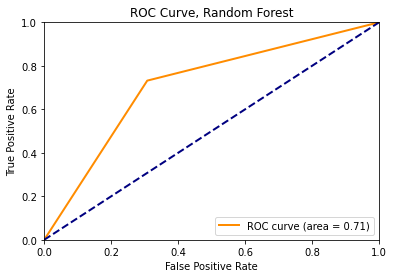

In [115]:
fpr, tpr, _ = metrics.roc_curve(ybi_test, ybi_predict)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, Random Forest')
plt.legend(loc = "lower right")
plt.show()

In [53]:
# binary is much better, use from now on

In [54]:
ft_imp = pd.DataFrame(data = RF_bi.feature_importances_, index= mb_mod_dummy.drop(['severity_ord','severity_bi'], axis = 1).columns)
ft_imp.sort_values(by= 0, ascending = False)

,0
hour,0.314192
month,0.285242
day_of_week,0.134416
speed_limit,0.093436
intersection,0.024407
road_pos_hor_straight,0.013024
road_pos_ver_level,0.012179
weekend,0.011163
traff_none,0.009776
light_darkness_lit,0.009284


Text(0, 0.5, 'Feature')

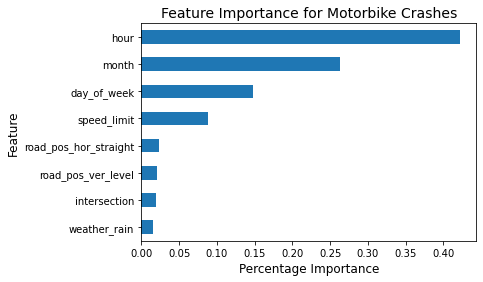

In [116]:
ft_imp.sort_values(by=0).plot(kind = 'barh', legend = False)
plt.title('Feature Importance for Motorbike Crashes', size = 14)
plt.xlabel('Percentage Importance', size = 12)
plt.ylabel('Feature', size = 12)
#plt.yticks(ticks = range(8),labels = ['Raining','Intersection','Flat Road','Straight Road', 'Speed Limit','Weekday','Month','Hour'])

In [57]:
mb_mod_tidy_binary = mb_mod_dummy[['month','day_of_week','hour','weekend','speed_limit','intersection','severity_bi','weather_rain',
                                              'light_darkness_lit','light_daylight','traff_none','road_pos_hor_straight','road_pos_ver_level',
                                             'road_pos_ver_slope']]

In [59]:
# Make a binary version too
Xbi = mb_mod_tidy_binary.drop(['severity_bi'], axis = 1)
ybi = mb_mod_tidy_binary['severity_bi']

Xbi_train, Xbi_test, ybi_train, ybi_test = train_test_split(Xbi, ybi, test_size = 0.3, random_state = 12321)

In [60]:
RF_bi = RandomForestClassifier()
RF_bi.fit(Xbi_train, ybi_train)

ybi_train_predict = RF_bi.predict(Xbi_train)
print(accuracy_score(ybi_train, ybi_train_predict))

ybi_predict = RF_bi.predict(Xbi_test)
print(accuracy_score(ybi_test, ybi_predict))

cm = confusion_matrix(ybi_test, ybi_predict)
print(cm)

print(classification_report(ybi_test, ybi_predict))

0.9224668860204168
0.7018994193484893
[[3434 1592]
 [1437 3698]]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      5026
           1       0.70      0.72      0.71      5135

    accuracy                           0.70     10161
   macro avg       0.70      0.70      0.70     10161
weighted avg       0.70      0.70      0.70     10161



In [64]:
ft_imp = pd.DataFrame(data = RF_bi.feature_importances_, index= mb_mod_tidy_binary.drop(['severity_bi'], axis = 1).columns)
ft_imp.sort_values(by= 0, ascending = False)

,0
hour,0.337888
month,0.288102
day_of_week,0.130888
speed_limit,0.092722
road_pos_hor_straight,0.026119
intersection,0.024324
weather_rain,0.017356
road_pos_ver_level,0.017276
traff_none,0.016901
light_daylight,0.014174


In [67]:
mb_final = mb_mod_tidy_binary[['hour','month','day_of_week','speed_limit','road_pos_hor_straight','intersection','weather_rain','road_pos_ver_level','severity_bi']]

In [68]:
Xbi = mb_final.drop(['severity_bi'], axis = 1)
ybi = mb_final['severity_bi']

Xbi_train, Xbi_test, ybi_train, ybi_test = train_test_split(Xbi, ybi, test_size = 0.3, random_state = 12321)

In [69]:
log_bi = LogisticRegression(solver = 'liblinear', max_iter = 300, random_state = 12321)

log_bi.fit(Xbi_train, ybi_train)

y_train_predict = log_bi.predict(Xbi_train)
print(accuracy_score(ybi_train, y_train_predict))

y_predict = log_bi.predict(Xbi_test)
print(accuracy_score(ybi_test, y_predict))

cm = confusion_matrix(ybi_test, y_predict)
print(cm)

print(classification_report(ybi_test, y_predict))

0.5895132034084198
0.5839976380277532
[[3294 1732]
 [2495 2640]]
              precision    recall  f1-score   support

           0       0.57      0.66      0.61      5026
           1       0.60      0.51      0.56      5135

    accuracy                           0.58     10161
   macro avg       0.59      0.58      0.58     10161
weighted avg       0.59      0.58      0.58     10161



In [70]:
DT_bi = DecisionTreeClassifier()
DT_bi.fit(Xbi_train, ybi_train)

ybi_train_predict = DT_bi.predict(Xbi_train)
print(accuracy_score(ybi_train, y_train_predict))

ybi_predict = DT_bi.predict(Xbi_test)
print(accuracy_score(ybi_test, ybi_predict))

cm = confusion_matrix(ybi_test, ybi_predict)
print(cm)

print(classification_report(ybi_test, ybi_predict))

0.5895132034084198
0.674933569530558
[[3552 1474]
 [1829 3306]]
              precision    recall  f1-score   support

           0       0.66      0.71      0.68      5026
           1       0.69      0.64      0.67      5135

    accuracy                           0.67     10161
   macro avg       0.68      0.68      0.67     10161
weighted avg       0.68      0.67      0.67     10161



In [71]:
RF_bi = RandomForestClassifier()
RF_bi.fit(Xbi_train, ybi_train)

ybi_train_predict = RF_bi.predict(Xbi_train)
print(accuracy_score(ybi_train, ybi_train_predict))

ybi_predict = RF_bi.predict(Xbi_test)
print(accuracy_score(ybi_test, ybi_predict))

cm = confusion_matrix(ybi_test, ybi_predict)
print(cm)

print(classification_report(ybi_test, ybi_predict))

0.8877499367248798
0.6790670209625037
[[3360 1666]
 [1595 3540]]
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      5026
           1       0.68      0.69      0.68      5135

    accuracy                           0.68     10161
   macro avg       0.68      0.68      0.68     10161
weighted avg       0.68      0.68      0.68     10161



In [76]:
ft_imp = pd.DataFrame(data = RF_bi.feature_importances_, index= mb_final.drop(['severity_bi'], axis = 1).columns)
ft_imp.sort_values(by= 0, ascending = False)

,0
hour,0.422422
month,0.263095
day_of_week,0.147932
speed_limit,0.088659
road_pos_hor_straight,0.022707
road_pos_ver_level,0.020642
intersection,0.019687
weather_rain,0.014857


([<matplotlib.axis.YTick at 0x1cac2182f48>,
 [Text(0, 0, 'Raining'),
  Text(0, 0, 'Intersection'),
  Text(0, 0, 'Flat Road'),
  Text(0, 0, 'Straight Road'),
  Text(0, 0, 'Speed Limit'),
  Text(0, 0, 'Weekday'),
  Text(0, 0, 'Month'),
  Text(0, 0, 'Hour')])

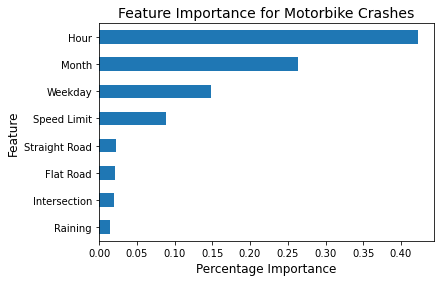

In [91]:
ft_imp.sort_values(by=0).plot(kind = 'barh', legend = False)
plt.title('Feature Importance for Motorbike Crashes', size = 14)
plt.xlabel('Percentage Importance', size = 12)
plt.ylabel('Feature', size = 12)
plt.yticks(ticks = range(8),labels = ['Raining','Intersection','Flat Road','Straight Road', 'Speed Limit','Weekday','Month','Hour'])

<Figure size 1800x576 with 0 Axes>

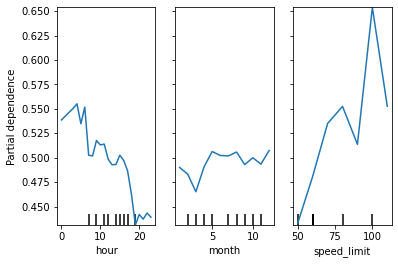

In [123]:
plt.figure(figsize = (25,8))
plot_partial_dependence(RF_bi, Xbi_train, features = ['hour','month','speed_limit'])

In [92]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 6)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300], 'max_depth': [1, 10, 20, 30, 40, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [93]:
rf_random = RandomizedSearchCV(estimator = RF_bi, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=3, random_state=12321, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xbi_train, ybi_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   52.4s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 10, 20, 30, 40, 50,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   random_state=12321, verbose=3)

In [94]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None}

In [95]:
rf_random = RandomizedSearchCV(estimator = RF_bi, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=12321, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xbi_train, ybi_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 10, 20, 30, 40, 50,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   random_state=12321, verbose=3)

In [96]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 30}

## Test with tuned params

In [106]:
RF_bi = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_depth = 30, random_state = 12321)
RF_bi.fit(Xbi_train, ybi_train)

ybi_train_predict = RF_bi.predict(Xbi_train)
print(accuracy_score(ybi_train, ybi_train_predict))

ybi_predict = RF_bi.predict(Xbi_test)
print(accuracy_score(ybi_test, ybi_predict))

cm = confusion_matrix(ybi_test, ybi_predict)
print(cm)

print(classification_report(ybi_test, ybi_predict))

0.8877499367248798
0.6775907883082374
[[3362 1664]
 [1612 3523]]
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      5026
           1       0.68      0.69      0.68      5135

    accuracy                           0.68     10161
   macro avg       0.68      0.68      0.68     10161
weighted avg       0.68      0.68      0.68     10161



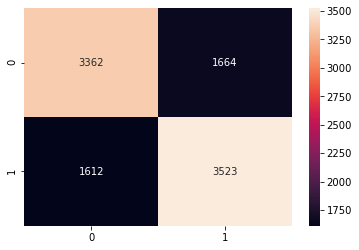

In [107]:
sns.heatmap(cm,annot=True,fmt="d")

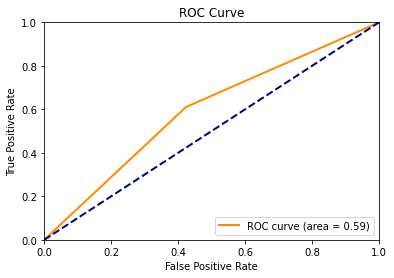

In [105]:
fpr, tpr, _ = metrics.roc_curve(ybi_test, ybi_predict)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = "lower right")
plt.show()

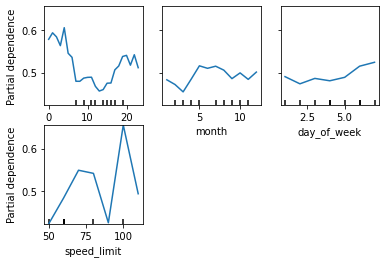

In [111]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(RF_bi, Xbi_train, ['hour','month','day_of_week','speed_limit'])

In [102]:
import xgboost as xgb

xgb_bi =xgb.XGBClassifier(random_state=12321,learning_rate=0.01)

xgb_bi.fit(Xbi_train, ybi_train)

ybi_train_predict = xgb_bi.predict(Xbi_train)
print(accuracy_score(ybi_train, ybi_train_predict))

ybi_predict = xgb_bi.predict(Xbi_test)
print(accuracy_score(ybi_test, ybi_predict))

cm = confusion_matrix(ybi_test, ybi_predict)
print(cm)

print(classification_report(ybi_test, ybi_predict))

0.6095081413988019
0.5937407735459108
[[2897 2129]
 [1999 3136]]
              precision    recall  f1-score   support

           0       0.59      0.58      0.58      5026
           1       0.60      0.61      0.60      5135

    accuracy                           0.59     10161
   macro avg       0.59      0.59      0.59     10161
weighted avg       0.59      0.59      0.59     10161



In [103]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=0.1)
abc_bi = abc.fit(Xbi_train, ybi_train)

ybi_train_predict = xgb_bi.predict(Xbi_train)
print(accuracy_score(ybi_train, ybi_train_predict))

ybi_predict = xgb_bi.predict(Xbi_test)
print(accuracy_score(ybi_test, ybi_predict))

cm = confusion_matrix(ybi_test, ybi_predict)
print(cm)

print(classification_report(ybi_test, ybi_predict))

0.6095081413988019
0.5937407735459108
[[2897 2129]
 [1999 3136]]
              precision    recall  f1-score   support

           0       0.59      0.58      0.58      5026
           1       0.60      0.61      0.60      5135

    accuracy                           0.59     10161
   macro avg       0.59      0.59      0.59     10161
weighted avg       0.59      0.59      0.59     10161

